# Digits generator

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2DTranspose, Conv2D

from keras.optimizers import SGD, RMSprop

Using TensorFlow backend.


## Data

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Visualisation

In [4]:
def reshape_image(pixels):
    npix = int(np.sqrt(pixels.shape[0]))
    return np.reshape(pixels, (npix, npix))

def draw_image(image):
    image = np.reshape(image, (image.shape[0], image.shape[1]))
    plt.imshow(image, cmap = plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

In [5]:
# draw_image(reshape_image(mnist.train.images[0]))

In [6]:
X_train = mnist.train.images.reshape(-1,  
                                     28, 
                                     28, 
                                     1).astype(np.float32)
y_train = mnist.train.labels

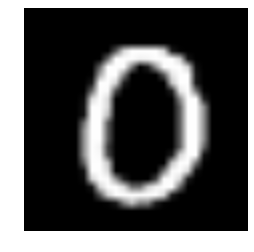

(None, array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]))

In [7]:
draw_image(X_train[10]), y_train[10]

In [8]:
X_train.shape

(55000, 28, 28, 1)

# GAN example
## Generator

In [9]:
gen_dropout = 0.4
gen_input_dim = 7
gen_depth = 128
gen_noise_dim = 50

In [10]:
gennet = Sequential()

# Input 
# fully-connected layer
gennet.add(Dense(gen_input_dim * gen_input_dim * gen_depth, 
                 input_dim=gen_noise_dim))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))
gennet.add(Reshape((gen_input_dim, gen_input_dim, gen_depth)))
gennet.add(Dropout(gen_dropout))

# Deconvolution layers
gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 2), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 4), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

gennet.add(Conv2DTranspose(int(gen_depth / 8), 5, padding='same'))
gennet.add(BatchNormalization(momentum=0.9))
gennet.add(Activation('relu'))

# Output
gennet.add(Conv2DTranspose(1, 5, padding='same'))
gennet.add(Activation('sigmoid'))

gennet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              319872    
_________________________________________________________________
batch_normalization_1 (Batch (None, 6272)              25088     
_________________________________________________________________
activation_1 (Activation)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        204864    
__________

## Discriminator

In [11]:
disc_depth = 64
disc_dropout = 0.4

In [12]:
discnet = Sequential()

# Input
discnet.add(Conv2D(disc_depth, 5, strides=2, input_shape=(28, 28, 1), 
                   padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*2, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*4, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*8, 5, strides=2, padding='same'))
discnet.add(Activation('relu'))
discnet.add(Dropout(disc_dropout))

# Out: scalar estimation of probability
discnet.add(Flatten())
discnet.add(Dense(1))
discnet.add(Activation('sigmoid'))

discnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
activation_6 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
activation_7 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
__________

## Discriminator model

In [13]:
discmodel = Sequential()
discmodel.add(discnet)
discmodel.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8),
                  metrics=['accuracy'])

## Adversarial model

In [14]:
advmodel = Sequential()
advmodel.add(gennet)
advmodel.add(discnet)
advmodel.compile(loss='binary_crossentropy', 
                 optimizer=RMSprop(lr=0.00084, clipvalue=1.0, decay=3e-8),
                 metrics=['accuracy'])

## Training

In [15]:
batch_size = 128
train_iters = 750

disc_losses = {"loss": [], "acc": []}
adv_losses = {"loss": [], "acc": []}

for i in range(train_iters):
    # Get random real images
    images_true = X_train[np.random.randint(0, 
                                            X_train.shape[0], 
                                            size=batch_size)]
    # Generate images from noise
    noise = np.random.uniform(-1.0, 1.0, 
                              size=[batch_size, gen_noise_dim])
    images_fake = gennet.predict(noise)
    # Compose training data for discriminator
    x = np.concatenate((images_fake, images_true))
    y = np.concatenate((np.zeros((batch_size, 1)), 
                        np.ones((batch_size, 1))))
    # Train discriminator on composed data
    dics_loss = discmodel.train_on_batch(x, y)
    disc_losses["loss"].append(dics_loss[0])
    disc_losses["acc"].append(dics_loss[1])
    
    # Compose trainig data for adversarial net
    noise = np.random.uniform(-1.0, 1.0, 
                              size=[batch_size, gen_noise_dim])
    y = np.ones([batch_size, 1])
    # Train adversarial net on composed data
    adv_loss = advmodel.train_on_batch(noise, y)
    adv_losses["loss"].append(adv_loss[0])
    adv_losses["acc"].append(adv_loss[1])
    
    # Print results
    print("{}th batch of {} |Disc loss {} |Disc acc {} |Adv loss {} |Adv acc {}".format(i, train_iters,
                                                                                       dics_loss[0], dics_loss[1], 
                                                                                       adv_loss[0], adv_loss[1]))

0th batch of 750 |Disc loss 0.6908715963363647 |Disc acc 0.5390625 |Adv loss 8.515299797058105 |Adv acc 0.0
1th batch of 750 |Disc loss 1.779516339302063 |Disc acc 0.5 |Adv loss 0.6732816100120544 |Adv acc 1.0
2th batch of 750 |Disc loss 0.6863710284233093 |Disc acc 0.5 |Adv loss 0.5678983926773071 |Adv acc 1.0
3th batch of 750 |Disc loss 2.0798258781433105 |Disc acc 0.5 |Adv loss 0.630908191204071 |Adv acc 1.0
4th batch of 750 |Disc loss 0.6305175423622131 |Disc acc 0.5 |Adv loss 0.35679835081100464 |Adv acc 1.0
5th batch of 750 |Disc loss 5.203568458557129 |Disc acc 0.5 |Adv loss 0.34034809470176697 |Adv acc 1.0
6th batch of 750 |Disc loss 2.5811681747436523 |Disc acc 0.5 |Adv loss 0.1597485989332199 |Adv acc 1.0
7th batch of 750 |Disc loss 2.721060037612915 |Disc acc 0.5 |Adv loss 0.10873483121395111 |Adv acc 1.0
8th batch of 750 |Disc loss 2.3227319717407227 |Disc acc 0.5 |Adv loss 0.0999387800693512 |Adv acc 1.0
9th batch of 750 |Disc loss 2.3042614459991455 |Disc acc 0.5 |Adv los

78th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
79th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
80th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
81th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
82th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
83th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
84th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
85th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
86th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
87th batch of 750 |Disc loss 7.971192359924316

156th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
157th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
158th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
159th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
160th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
161th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
162th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
163th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
164th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
165th batch of 750 |Disc loss 7.97119

234th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
235th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
236th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
237th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
238th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
239th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
240th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
241th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
242th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
243th batch of 750 |Disc loss 7.97119

312th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
313th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
314th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
315th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
316th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
317th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
318th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
319th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
320th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
321th batch of 750 |Disc loss 7.97119

390th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
391th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
392th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
393th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
394th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
395th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
396th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
397th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
398th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
399th batch of 750 |Disc loss 7.97119

468th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
469th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
470th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
471th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
472th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
473th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
474th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
475th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
476th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
477th batch of 750 |Disc loss 7.97119

546th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
547th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
548th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
549th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
550th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
551th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
552th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
553th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
554th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
555th batch of 750 |Disc loss 7.97119

624th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
625th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
626th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
627th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
628th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
629th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
630th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
631th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
632th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
633th batch of 750 |Disc loss 7.97119

702th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
703th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
704th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
705th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
706th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
707th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
708th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
709th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
710th batch of 750 |Disc loss 7.971192359924316 |Disc acc 0.5 |Adv loss 1.192093321833454e-07 |Adv acc 1.0
711th batch of 750 |Disc loss 7.97119

## Discriminator losses

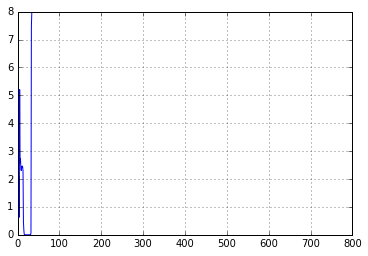

In [16]:
plt.plot(list(range(train_iters)), disc_losses["loss"])
plt.grid()

## Adversarial net losses

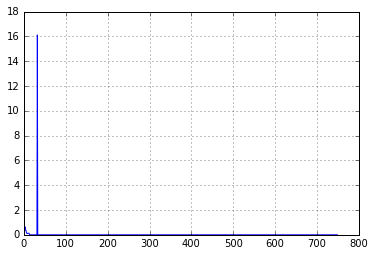

In [17]:
plt.plot(list(range(train_iters)), adv_losses["loss"])
plt.grid()